In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Place'

/content/drive/My Drive/Siamese/Place


In [3]:
import sys
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')
sys.path.insert(0, '../Speaker')
sys.path.insert(0, '../Conference')
sys.path.insert(0, '..')

In [4]:
!pip install torchaudio

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 6

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType
from torchvision.transforms import Compose

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Conference(DEVICE, time=True)
net.to(DEVICE)

Conference(
  (encoder): Time(
    (avgpool): AvgPool1d(kernel_size=(7,), stride=(4,), padding=(0,))
    (block1): Conv1DBlock(
      (conv): Conv1d(1, 128, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv1DBlock(
      (conv): Conv1d(128, 256, kernel_size=(7,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=7, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv1DBlock(
      (conv1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(256, 192, kernel_size=(3,), stride=(1,), padding=(1,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block4):

In [9]:
with torch.no_grad():
  # test
  net.eval()
  # Store the places
  speakers_list = testset.get_speakers_list(20)
  net.load_encoder()
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list, maxsize=3)

Encoder loaded


In [10]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []
  final_mean_accuracies = []
  final_min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    final_mean_accuracy = 0
    final_min_accuracy = 0
    nb_test = 0

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      gold_label = gold_label.item()
      mean_label, topk_label, min_label = net(sample, gold_label)
      final_mean_label, final_min_label = net(sample, place_id=gold_label)
      nb_test += 1
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1
      if gold_label == final_mean_label:
        final_mean_accuracy += 1
      if gold_label == final_min_label:
        final_min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    final_mean_accuracy /= nb_test
    final_min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    final_mean_accuracies.append(final_mean_accuracy)
    final_min_accuracies.append(final_min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    print("accuracy final_mean ", final_mean_accuracy, 
          " final_min ", final_min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

*** Epoch  0  ***


2134it [01:52, 18.91it/s]

accuracy mean  0.3983130271790066 topk 0.5567010309278351  min  0.53514526710403
accuracy final_mean  0.7619493908153702  final_min  0.6991565135895033
Error  0.44329896907216493
{270: 63, 272: 72, 273: 70, 274: 59, 275: 51, 276: 36, 277: 35, 278: 11, 271: 57, 279: 57, 280: 43, 281: 23, 282: 53, 283: 33, 285: 49, 284: 27, 286: 28, 287: 52, 288: 93, 289: 28}
*** Epoch  1  ***



2134it [01:01, 34.60it/s]

accuracy mean  0.45313964386129335 topk 0.5899718837863168  min  0.5712277413308341
accuracy final_mean  0.8392689784442362  final_min  0.7343017806935332
Error  0.41002811621368324
{270: 36, 272: 72, 273: 62, 274: 61, 275: 33, 276: 36, 277: 31, 278: 18, 271: 46, 279: 50, 280: 47, 281: 34, 282: 41, 283: 39, 285: 47, 284: 30, 286: 26, 287: 47, 288: 81, 289: 24}
*** Epoch  2  ***



2134it [01:01, 34.54it/s]

accuracy mean  0.4967197750702905 topk 0.598875351452671  min  0.584348641049672
accuracy final_mean  0.852389878163074  final_min  0.753045923149016
Error  0.40112464854732893
{270: 32, 272: 64, 273: 67, 274: 50, 275: 31, 276: 32, 277: 31, 278: 24, 271: 42, 279: 47, 280: 41, 281: 39, 282: 42, 283: 38, 285: 50, 284: 30, 286: 26, 287: 43, 288: 66, 289: 25}
*** Epoch  3  ***



2134it [01:01, 34.86it/s]


accuracy mean  0.528584817244611 topk 0.5998125585754451  min  0.5979381443298969
accuracy final_mean  0.8622305529522024  final_min  0.760543580131209
Error  0.4001874414245548
{270: 34, 272: 60, 273: 66, 274: 46, 275: 32, 276: 34, 277: 26, 278: 28, 271: 39, 279: 46, 280: 43, 281: 44, 282: 36, 283: 39, 285: 47, 284: 30, 286: 30, 287: 41, 288: 43, 289: 25}
*** Epoch  4  ***


2134it [01:01, 34.80it/s]

accuracy mean  0.5201499531396439 topk 0.5937207122774133  min  0.5895032802249297
accuracy final_mean  0.8434864104967198  final_min  0.7516401124648547
Error  0.4062792877225867
{270: 36, 272: 56, 273: 69, 274: 50, 275: 32, 276: 38, 277: 26, 278: 28, 271: 36, 279: 44, 280: 44, 281: 47, 282: 38, 283: 41, 285: 39, 284: 30, 286: 30, 287: 37, 288: 39, 289: 25}
*** Epoch  5  ***



2134it [01:01, 34.60it/s]

accuracy mean  0.5168697282099344 topk 0.5880974695407685  min  0.5801312089971884
accuracy final_mean  0.8434864104967198  final_min  0.7497656982193065
Error  0.4119025304592315
{270: 36, 272: 52, 273: 70, 274: 50, 275: 32, 276: 38, 277: 26, 278: 29, 271: 32, 279: 44, 280: 47, 281: 47, 282: 39, 283: 44, 285: 40, 284: 28, 286: 30, 287: 37, 288: 41, 289: 28}


In [11]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))
print("maximum of final mean", round(np.max(final_mean_accuracies), 3))
print("maximum of final min", round(np.max(final_mean_accuracies), 3))

maximum of min 0.598
maximum of topk 0.6
maximum of mean 0.529
maximum of final mean 0.862
maximum of final min 0.862


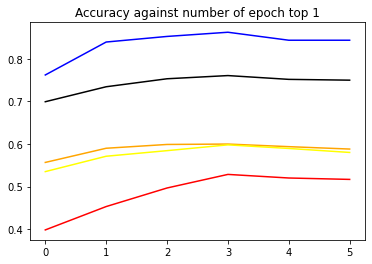

In [12]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='orange')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='yellow')
plt.plot([i for i in range(EPOCH_NUM)], final_mean_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], final_min_accuracies , label='test 1', color='black')